<a href="https://colab.research.google.com/github/ryoshumei/GraduationThesis/blob/main/source_code_used_for_this_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import shutil
import random

In [ ]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


## データの読み込み

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
!unzip -q data_onetrain360.zip -d /content/
%cd /content/


/content/drive/MyDrive/Colab Notebooks
/content


In [ ]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224),scale=(0.2,1), ratio=(0.75,1.333)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine([0,360], scale=(0.5, 1.5)), 
        
        transforms.RandomPerspective(distortion_scale=(random.uniform(0.0, 0.6)), p=0.5),
        transforms.ColorJitter(brightness=(0.3,1.5), contrast=(0.0,5.0),saturation=(0,5), hue=(0.00,0.06)),
        transforms.ToTensor(),
        
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop((224,224),scale=(0.3,1), ratio=(0.75,1.333)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomAffine([0,360], scale=(0.6, 1.3)), 
        transforms.RandomPerspective(distortion_scale=(random.uniform(0.0, 0.4)), p=0.5),
        transforms.ToTensor(),
    ]),
}


In [ ]:
#画像とラベルを読み込む
from torch.utils.data import ConcatDataset
data_dir = 'data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                                                  data_transforms['train'])
train_dataset_new1 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                                                  data_transforms['train'])
train_dataset_new2 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                                                  data_transforms['train'])
train_dataset_new3 = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                                                  data_transforms['train'])

train_dataset = ConcatDataset([train_dataset, train_dataset_new1,train_dataset_new2,train_dataset_new3])


val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                                                data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50,
                                             shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50,
                                             shuffle=False, num_workers=2)
#print(train_dataset_new2)
print(train_dataset_new1)
print(val_dataset)


Dataset ImageFolder
    Number of datapoints: 1800
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.2, 1), ratio=(0.75, 1.333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=[0.0, 360.0], scale=(0.5, 1.5))
               RandomPerspective(p=0.5)
               ColorJitter(brightness=(0.3, 1.5), contrast=(0.0, 5.0), saturation=(0, 5), hue=(0.0, 0.06))
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 250
    Root location: data/val
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.3, 1), ratio=(0.75, 1.333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=[0.0, 360.0], scale=(0.6, 1.3))
           

## 学習

In [ ]:
#全結合の次元を計算
size_check = torch.FloatTensor(300, 3, 224, 224)
features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
#バッチサイズ10, 6×6のフィルターが256枚
#10バッチは残して、6×6×256を１次元に落とす=>6×6×256=9216
print(features(size_check).size())
#バッチ１０の値を軸にして残りの次元を１次元へ落とした場合のTensorの形状をチェックすると9216。
print(features(size_check).view(size_check.size(0), -1).size())
#fc_sizeを全結合の形状として保持しておく
fc_size = features(size_check).view(size_check.size(0), -1).size()[1]
print(fc_size)

torch.Size([300, 256, 6, 6])
torch.Size([300, 9216])
9216


In [ ]:
num_classes = 5

class AlexNet(nn.Module):
    #fc_sizeを引き渡す
    def __init__(self, num_classes, fc_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), #1   
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),#2           
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),#3            
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),#4            
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),#5            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        #fc_sizeで計算した形状を指定
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.9),
            nn.Linear(fc_size, 4096), #1
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.9),
            nn.Linear(4096, 4096),#2
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)#3
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes, fc_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=6e-3) 

In [ ]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.9, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.9, 

In [ ]:
num_epochs = 100

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, train_acc: {train_acc:.4f} ,val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, train_acc = avg_train_acc ,val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.0322, train_acc: 0.1978 ,val_loss: 0.0322, val_acc: 0.2000
Epoch [2/100], Loss: 0.0322, train_acc: 0.2031 ,val_loss: 0.0322, val_acc: 0.3000
Epoch [3/100], Loss: 0.0321, train_acc: 0.2013 ,val_loss: 0.0322, val_acc: 0.3080
Epoch [4/100], Loss: 0.0300, train_acc: 0.2297 ,val_loss: 0.0298, val_acc: 0.4080
Epoch [5/100], Loss: 0.0254, train_acc: 0.4185 ,val_loss: 0.0264, val_acc: 0.5080
Epoch [6/100], Loss: 0.0237, train_acc: 0.4875 ,val_loss: 0.0259, val_acc: 0.5000
Epoch [7/100], Loss: 0.0224, train_acc: 0.5328 ,val_loss: 0.0254, val_acc: 0.4840
Epoch [8/100], Loss: 0.0212, train_acc: 0.5706 ,val_loss: 0.0252, val_acc: 0.5080
Epoch [9/100], Loss: 0.0199, train_acc: 0.6010 ,val_loss: 0.0244, val_acc: 0.4720
Epoch [10/100], Loss: 0.0170, train_acc: 0.6546 ,val_loss: 0.0339, val_acc: 0.5600
Epoch [11/100], Loss: 0.0142, train_acc: 0.6885 ,val_loss: 0.0276, val_acc: 0.5600
Epoch [12/100], Loss: 0.0128, train_acc: 0.7108 ,val_loss: 0.0247, val_acc: 0.6040
Epoch [13/100

log20221209 21:03
 learned about 3000epochs\\
can find dif between learning data and val_data
using only one learning_data


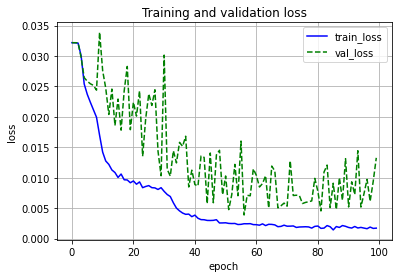

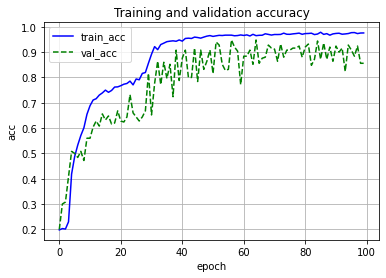

In [ ]:
#2023/01/25_1
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

### TESTING 

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
!unzip -q final_test.zip -d /content/
%cd /content/

/content/drive/MyDrive/Colab Notebooks
/content


In [ ]:
testing_transforms = transforms.Compose([
        transforms.CenterCrop(2000),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])

In [ ]:
%cd /content/

/content


In [ ]:
data_dir = 'final_test'
testing_dataset = datasets.ImageFolder(data_dir,testing_transforms)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=50, shuffle=False)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


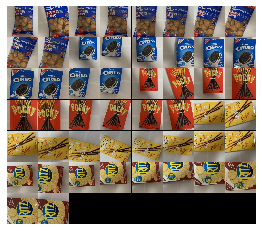

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(test_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

In [ ]:
testing_lable_list = []
    
#testing 
net.eval()

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    outputs = net(images)
    testing_lable_list.extend(outputs.max(1)[1].tolist())
print(testing_lable_list)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
#save testing_result to csv file
import csv
filename = "testing_result_with_big_image.csv"
data = [[i] for i in testing_lable_list]
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
#save paremeters
torch.save(net.state_dict(), 'model_weight_20230125.pth')


In [ ]:
#save whole model
torch.save(net, 'model_whole_20230125.pth')